<a href="https://colab.research.google.com/github/steelannelida/nanoGPT/blob/master/nanogpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/steelannelida/nanoGPT.git

Cloning into 'nanoGPT'...
remote: Enumerating objects: 697, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 697 (delta 8), reused 10 (delta 6), pack-reused 682 (from 1)
Receiving objects: 100% (697/697), 964.74 KiB | 27.56 MiB/s, done.
Resolving deltas: 100% (393/393), done.


In [3]:
!pip install torch numpy transformers datasets tiktoken wandb tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.3 MB/s eta 0:00:00


In [4]:
!yes  | python nanoGPT/data/shakespeare/prepare.py

train has 301,966 tokens
val has 36,059 tokens


In [5]:
with open('nanoGPT/data/shakespeare/input.txt') as f:
  text = f.read()

chars = sorted(set(text))
vocab_size=len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}

def encode(t):
  return [stoi[c] for c in t]

def decode(seq):
  return ''.join([chars[i] for i in seq])

decode(encode("sandwitch"))

'sandwitch'

In [6]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data = torch.tensor(encode(text), device=device)
data.shape, data.dtype

n = int(data.shape[0] * 0.9)
train_data = data[:n]
valid_data = data[n:]

In [7]:
#torch.manual_seed(1337)


def get_batch(data_set=train_data, batch_size=32, seq_length=128):
    x = torch.zeros([batch_size, seq_length], dtype=torch.int, device=device)
    y = torch.zeros([batch_size, seq_length], dtype=torch.int, device=device)
    for b in range(batch_size):
        t = torch.randint(0, data_set.shape[0] - seq_length - 1, [1])
        x[b] = data_set[t:t+seq_length]
        y[b] = data_set[t+1:t+seq_length+1]
    return x, y

x, y = get_batch()
print(decode(x[13]))
print(decode(y[13]))

appiness.
Go, then my mother, to thy daughter go
Make bold her bashful years with your experience;
Prepare her ears to hear a wo
ppiness.
Go, then my mother, to thy daughter go
Make bold her bashful years with your experience;
Prepare her ears to hear a woo


In [8]:
import random
arith_chars = '0123456789-=*+'
arith_idx = {c:idx for idx, c in enumerate(arith_chars)}


def gen_expression(digits=5, terms=3):
  s = ''
  for i in range(terms):
    if i > 0:
      s += random.choice('*-+')
    num = ''
    for j in range(digits):
      num += random.choice('0123456789')
    num = str(int(num))
    s += num
  return s

def gen_eq():
  expr = gen_expression()
  value = eval(expr)
  return f'{expr}={value}'

gen_eq()


'30653+30885*59497=1837595498'

In [9]:
import torch.nn as nn

class DecoderLayer(nn.Module):
  def __init__(self, embed_size=256, wide_size=1024, nheads=16, dropout=0.5):
    super().__init__()
    self.attn = nn.MultiheadAttention(embed_size, nheads,
                                      batch_first=True)
    self.ln1 = nn.LayerNorm(embed_size)
    self.ln2 = nn.LayerNorm(embed_size)
    self.lin1 = nn.Linear(embed_size, wide_size)
    self.lin2 = nn.Linear(wide_size, embed_size)
    self.drop = nn.Dropout(dropout)

  def forward(self, x, mask):
    x = self.ln1(x)
    a, w = self.attn.forward(x, x, x, attn_mask=mask, is_causal=True)
    x = x + self.drop(a)
    x = self.ln2(x)
    xx = self.lin1(x)
    xx = nn.functional.gelu(xx)
    y = self.lin2(xx)
    return x + y



class LM(nn.Module):
  def __init__(self, vocab_size, embed_size=256, nheads=16, max_pos=2048, num_layers=3, dropout=0.5):
    super().__init__()
    self.embeddings = nn.Embedding(vocab_size, embed_size)
    self.pos_embeddings = nn.Embedding(max_pos, embed_size)
    self.layers = [
        DecoderLayer(embed_size=embed_size, wide_size=4 * embed_size,
                     nheads=nheads, dropout=dropout)
        for _ in range(num_layers)
    ]
    for i, layer in enumerate(self.layers):
      self.add_module(f'decoder-{i}', layer)
    self.ln = nn.LayerNorm(embed_size)
    self.out = nn.Linear(embed_size, vocab_size)
    self.max_pos = max_pos
    self.to(device)

  def forward(self, idx):
    idx = torch.tensor(idx, device=device)
    l = idx.shape[-1]
    pe = self.pos_embeddings(torch.arange(0, l, device=device))
    e = self.embeddings(idx)
    e = e + pe.view(1, *pe.shape)
    mask = ~torch.tril(torch.ones([l, l], dtype=torch.bool, device=device))
    #print(mask)
    #print(w)
    for layer in self.layers:
      e = layer(e, mask)
    logits = self.out.forward(self.ln(e))
    return logits

  def generate(self, prompt, l):
    prompt = torch.tensor(prompt)
    pl = prompt.shape[0]
    result = torch.zeros([pl + l], dtype=torch.int, device=device)
    result[:pl] = prompt
    for i in range(l):
      logits = self.forward(result[:pl + i])
      sm = logits[:,-1].flatten().softmax(0)
      next_idx = torch.multinomial(sm, 1)
      result[i+pl] = next_idx
    return result

model = LM(vocab_size)

k=x
q=x[:,:-1]
model.forward(encode('jello'))
decode(model.generate(encode('hello'), 10))

<ipython-input-9-e0d01c3d5bba>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  idx = torch.tensor(idx, device=device)


'helloz\nDGIUhVb$'

In [10]:
x, y = get_batch()
logits = model(x)
loss_fun = nn.CrossEntropyLoss()
loss = loss_fun(logits.permute(0, 2, 1), y.long())
loss

<ipython-input-9-e0d01c3d5bba>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  idx = torch.tensor(idx, device=device)


tensor(4.3659, device='cuda:0', grad_fn=<NllLoss2DBackward0>)

In [21]:
torch.manual_seed(1337)

model = LM(vocab_size)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
xv, yv = get_batch(valid_data, batch_size=256)
scaler = torch.cuda.amp.GradScaler()

<ipython-input-21-4de558c3f791>:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [ ]:

for step in range(5000):
  x, y = get_batch(batch_size=64, seq_length=512)
  with torch.autocast(device_type='cuda', dtype=torch.float16):
    model.train()
    logits = model.forward(x)
    loss = loss_fun(logits.permute(0, 2, 1), y.long())

  scaler.scale(loss).backward()
  scaler.step(opt)
  scaler.update()
  opt.zero_grad()

  if step % 10 == 0:
    with torch.no_grad():
      with torch.autocast(device_type='cuda', dtype=torch.float16):
        model.eval()
        vlogits = model.forward(xv)
        vloss = loss_fun(vlogits.permute(0,2,1), yv.long())
      print('%d\t%f\t%f'%(step, loss, vloss))


<ipython-input-9-e0d01c3d5bba>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  idx = torch.tensor(idx, device=device)


0	4.324711	3.536386
10	2.774782	2.758127
20	2.619682	2.608913
30	2.554018	2.554540
40	2.516207	2.533410
50	2.498862	2.513678
60	2.492850	2.504798
70	2.485012	2.489286
80	2.487870	2.490611
90	2.458931	2.480279
100	2.458351	2.467422
110	2.453715	2.457272
120	2.458201	2.455853
130	2.450221	2.450799
140	2.444617	2.437501
150	2.437819	2.431247
160	2.445818	2.422714
170	2.430912	2.403736
180	2.401484	2.404512
190	2.419736	2.400772
200	2.398404	2.379988
210	2.399468	2.375996
220	2.377149	2.358108
230	2.379761	2.365486
240	2.367636	2.363358
250	2.347146	2.330816
260	2.343889	2.335374
270	2.349544	2.341244
280	2.329063	2.310404
290	2.315458	2.317228
300	2.311305	2.317369
310	2.297817	2.293697
320	2.284091	2.280419
330	2.297337	2.268953
340	2.234494	2.257608
350	2.298684	2.307758
360	2.272735	2.261325
370	2.331840	2.234465
380	2.234538	2.224164
390	2.193740	2.209790
400	2.198978	2.196601
410	2.162051	2.206730
420	2.297836	2.286490
430	2.254257	2.223340
440	2.237198	2.195550
450	2.193673	2.176476

In [13]:
with torch.no_grad():
  with torch.autocast(device_type='cuda', dtype=torch.float16):
    model.eval()
    print(decode(model.generate(encode('To dream'), 256)))

<ipython-input-9-e0d01c3d5bba>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  idx = torch.tensor(idx, device=device)


To dreamist, tee'swaronis ayous honopare wed my pugre thishe, out ston.
As tofit iveced amy
G, fe rl incha bl bu,
Wo had, an
MELer; my wAst whenomalervpaire: the y thar renovin

To nsweay th ineay, s Rico he s ipry f fofrsr w shithaspd we mitho

Ad d mothe
I HAnd 


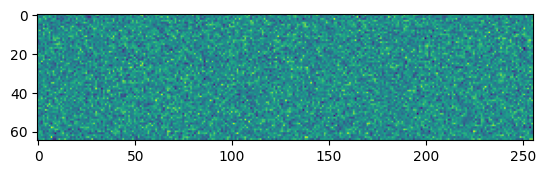

In [14]:
import matplotlib.pyplot as plt

plt.imshow(model.embeddings.weight.detach().cpu().numpy())
# plt.plot(model.pos_embeddings.weight[:,37].detach().cpu().numpy())
# plt.plot(model.pos_embeddings.weight[:,4].detach().cpu().numpy())


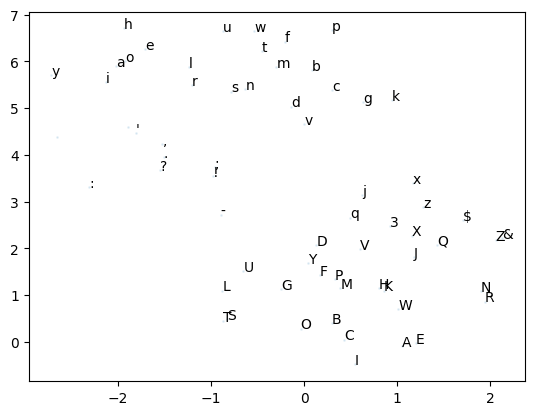

In [15]:
from sklearn.manifold import TSNE

tsne = TSNE()
y = tsne.fit_transform(model.out.weight.detach().cpu().numpy())

plt.scatter(y[:,0], y[:,1], s=1, alpha=0.1)
for i, c in enumerate(chars):
  plt.text(y[i,0], y[i,1], c)

In [16]:
model.out.weight.shape

torch.Size([65, 256])